In [37]:
from library.optimiser import *
from library.objective_function import *
from library.post_analysis import *
from library.experiments import *

import os
import json
import deep_sdf.workspace as ws
import seaborn as sns

In [2]:
def adjust_learning_rate(initial_lr, optimizer, num_iterations, decreased_by, adjust_lr_every):
    lr = initial_lr * ((1 / decreased_by) ** (num_iterations // adjust_lr_every))
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

class argms:
    def __init__(self):
        self.experiment_directory = "example1"
        self.checkpoint = "latest"
        self.iterations = 100
        self.split_filename = "example1/synth_test.json"
        self.logfile = None
        self.debug = False
        self.quiet = False

def getLatentSourceAndTarget(args, source_id, target_id):
    # pick initialization and samples
    # Load collection of all latent codes
    all_codes_path = os.path.join(
        args.experiment_directory,
        ws.latent_codes_subdir,
        'latest.pth')
    all_codes = torch.load(all_codes_path)['latent_codes']['weight']
    ## sphere
    source_id = 999 # zywvjkvz2492e6xpq4hd1jzy2r9lht        # This will be the source shape (ie starting point)
    latent = all_codes[source_id].unsqueeze(0).detach().cuda()   #Add .cuda() if you want to run on GPU
    latent.requires_grad = True

    # This is be the target shape (ie objective)
    latent_target = all_codes[target_id].unsqueeze(0).detach().cuda()   #Add .cuda() if you want to run on GPU
    return latent, latent_target

def constructDecoder(args):
    specs_filename = os.path.join(args.experiment_directory, "specs.json")
    specs = json.load(open(specs_filename))
    arch = __import__("networks." + specs["NetworkArch"], fromlist=["Decoder"])
    latent_size = specs["CodeLength"]
    # Load decoder: this is our black box function
    decoder = arch.Decoder(latent_size, **specs["NetworkSpecs"])
    decoder = torch.nn.DataParallel(decoder)
    saved_model_state = torch.load(
        os.path.join(
            args.experiment_directory, ws.model_params_subdir, args.checkpoint + ".pth"
        ),
       # map_location=torch.device('cpu') # Remove this if you want to run on GPU
    )
    decoder.load_state_dict(saved_model_state["model_state_dict"])
    # Optionally: put decoder on GPU
    decoder = decoder.module.cuda()
    return decoder


class argms:
    def __init__(self):
        self.experiment_directory = "example1"
        self.checkpoint = "latest"
        self.iterations = 400
        self.split_filename = "example1/synth_test.json"
        self.logfile = None
        self.debug = False
        self.quiet = False

In [3]:
args = argms()

N_MARCHING_CUBE = 64
l2reg= True
source_id = 999 
target_id = 2 
latent, latent_target = getLatentSourceAndTarget(args, source_id, target_id)


decoder = constructDecoder(args)
objectiveDe = decoder_obj(latent_target, decoder)

In [ ]:
torch.manual_seed(0)
l2reg= True
# 1 prepare data
## sphere
source_id = 999 # zywvjkvz2492e6xpq4hd1jzy2r9lht        # This will be the source shape (ie starting point)
## torus
target_id = 2 # 0bucd9ryckhaqtqvbiagilujeqzek4  
latent, latent_target = getLatentSourceAndTarget(args, source_id, target_id)
latent = latent.detach()

# 2 prepare model
decoder = constructDecoder(args)

# init and setup one experiment
exp = single_experiment()
# One experiment: setup objective function
objectiveDe = decoder_obj(latent_target, decoder)
exp.set_objective(objectiveDe)
opt = cma_es(dim=8)
optParas ={'x0': latent,
           'std': torch.ones((8,), device=torch.device('cuda:0')) * 0.03, 
           'tol': 1e-6, 
           'adjust_func': do_nothing(), 
           'record': True, 
           'max_iter': 400,
           'cluster_size': 6,
           'verbose': True}
opt.set_parameters(optParas)
exp.set_optimizer(opt)
%time stats = exp.do()

iter:  400
loss:  0.0006828273180872202
latent:  [-0.01385261 -0.37178156  0.0704284   0.14542419  0.05958317  0.21042673
  0.17752883 -0.15387535]


eigenvalue of variance = tensor([0.1940, 0.0789, 0.0576, 0.0214, 0.0140, 0.0091, 0.0012, 0.0028],
       device='cuda:0')
total iterations = 400, total evaluatios = 2400
found minimum position = [-0.01349017 -0.37077475  0.07075483  0.14932723  0.0578967   0.21074085
  0.17765619 -0.15109324], found minimum = 0.0006763504352420568
distance domain, codomain:  tensor(0.1458, device='cuda:0') tensor(0.0007, device='cuda:0')
Result:  global minimum
found minimum: 0.0006763504352420568, minimum position: tensor([-0.0135, -0.3708,  0.0708,  0.1493,  0.0579,  0.2107,  0.1777, -0.1511],
       device='cuda:0'), evals: 2400
CPU times: user 1h 10min 57s, sys: 5min 54s, total: 1h 16min 52s
Wall time: 3min 50s

In [8]:
latent_target

tensor([[-0.0562, -0.2882,  0.1230,  0.2264,  0.0941,  0.1983,  0.1402, -0.1180]],
       device='cuda:0')

In [18]:
np.linalg.norm(latent_target.cpu().numpy() - stats['arg'][-1][1])

0.14569072

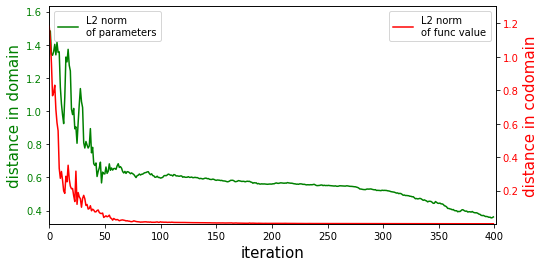

In [11]:
ana = post_analysis_single(stats)
ana.plot_distance()

In [29]:
latent

tensor([[-0.3412, -0.4759, -0.1524,  0.0231,  0.1486,  0.3323, -0.1601, -0.1239]],
       device='cuda:0')

In [131]:
torch.manual_seed(0)
l2reg= True
# 1 prepare data
## sphere
source_id = 999 # zywvjkvz2492e6xpq4hd1jzy2r9lht        # This will be the source shape (ie starting point)
## torus
target_id = 2 # 0bucd9ryckhaqtqvbiagilujeqzek4  
latent, latent_target = getLatentSourceAndTarget(args, source_id, target_id)
latent = latent.detach()

# 2 prepare model
decoder = constructDecoder(args)

# init and setup one experiment
exp = single_experiment()
# One experiment: setup objective function
objectiveDe = decoder_obj(latent_target, decoder)
exp.set_objective(objectiveDe)
ln = line_search()
optParas = {
    'x0': latent,
    'alpha': 0.5,
    'beta': 0.01, 
    'max_iter': 3,
    'tol': 1e-3,              
    'verbose': True,
    'record': True
}
ln.set_parameters(optParas)
exp.set_optimizer(ln)
%time stats_adam = exp.do()

at begining, loss:  0.486166775226593 0.35554933547973633

*******starting optimisation from intitial point:  [-0.34123307 -0.47586045 -0.15240912  0.02312643  0.14862083  0.3323207
 -0.16005228 -0.12385195]
tensor([ 0.1635,  0.1335,  0.0575, -0.1267, -0.0714, -0.2313,  0.0029,  0.0742],
       device='cuda:0') torch.Size([8])
iter:  0
loss:  0.2609418034553528
stepsize:  0.5


tensor([ 0.1734,  0.1442,  0.0583, -0.1367, -0.0775, -0.2477,  0.0004,  0.0799],
       device='cuda:0') torch.Size([8])
iter:  1
loss:  0.25837764143943787
stepsize:  0.5


tensor([ 2.2830e-02,  1.8474e-02,  8.2407e-03, -1.7414e-02, -1.0149e-02,
        -3.1968e-02, -5.6182e-05,  9.7772e-03], device='cuda:0') torch.Size([8])
iter:  2
loss:  0.25964078307151794
stepsize:  0.5


total evaluatios = 9
gradient at stop position = [-0.01424643 -0.01114668 -0.00553529  0.01048487  0.00640702  0.01948364
  0.00035204 -0.00550625]
found minimum position = [-0.16139337 -0.3277747  -0.09035415 -0.11731099  0.06909847  0.0

In [134]:
stats_adam['arg'].shape

(4, 8)

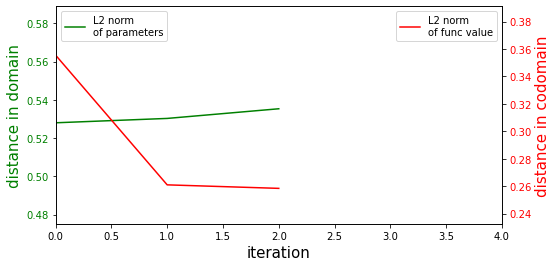

In [136]:
ana_adam = post_analysis_single(stats_adam)
ana_adam.plot_distance()

In [25]:
final_ln = torch.tensor([-0.1614, -0.3278, -0.0904, -0.1173,  0.0691,  0.0768, -0.1584, -0.0419])
verts, faces = create_mesh_optim(decoder, final_ln.cuda(), N=N_MARCHING_CUBE, max_batch=int(2 ** 18))
write_verts_faces_to_file(verts, faces, "data/final_ln.ply")
print("distance in domain: ", torch.norm(final_ln-latent_target.cpu()))

distance in domain:  tensor(0.5353)


In [147]:
torch.manual_seed(0)
l2reg= True
# 1 prepare data
## sphere
source_id = 999 # zywvjkvz2492e6xpq4hd1jzy2r9lht        # This will be the source shape (ie starting point)
## torus
target_id = 2 # 0bucd9ryckhaqtqvbiagilujeqzek4  
latent, latent_target = getLatentSourceAndTarget(args, source_id, target_id)
latent = latent.detach()

# 2 prepare model
decoder = constructDecoder(args)

# init and setup one experiment
exp = single_experiment()
# One experiment: setup objective function
objectiveDe = decoder_obj(latent_target, decoder)
exp.set_objective(objectiveDe)
opt = cma_es(dim=8)
ln = line_search()
optParas = {
    'x0': latent,
    'alpha': 0.1,
    'beta': 0.01, 
    'max_iter': 10,
    'tol': 1e-1,              
    'verbose': False,
    'record': False
}
ln.set_parameters(optParas)
optParas ={'x0': latent,
           'std': torch.ones((8,), device=torch.device('cuda:0')) * 0.03, 
           'tol': 1e-6, 
           'adjust_func': ln, 
           'record': True, 
           'max_iter': 10,
           'cluster_size': 6,
           'verbose': True}
opt.set_parameters(optParas)
exp.set_optimizer(opt)
%time stats_mix = exp.do()



*******starting optimisation from intitial mean:  [-0.34123307 -0.47586045 -0.15240912  0.02312643  0.14862083  0.3323207
 -0.16005228 -0.12385195]
iter:  1
loss:  0.16319231688976288
latent:  [-0.12738423 -0.3915442   0.0147555  -0.09510791  0.08079793  0.12586793
 -0.22398303 -0.18041675]


iter:  2
loss:  0.1484934687614441
latent:  [-0.12886274 -0.42662758  0.04839256 -0.05283027  0.01385724  0.18166542
 -0.18001656 -0.16028194]


iter:  3
loss:  0.14715003967285156
latent:  [-0.06728368 -0.47153464  0.00417009 -0.18527931  0.04405157  0.2538182
 -0.1505259  -0.19863307]


iter:  4
loss:  0.13271622359752655
latent:  [-0.15856552 -0.61249644  0.0872437  -0.21177201  0.14328995  0.0279884
 -0.17926592 -0.40533525]


iter:  5
loss:  0.11603526771068573
latent:  [-0.11106826 -0.57366383  0.17543979 -0.03786654 -0.06219728  0.16533738
 -0.08592249 -0.31744725]


iter:  6
loss:  0.045838113874197006
latent:  [-0.04583871 -0.61749274 -0.02149319 -0.13248217  0.14642657  0.04970182
  0.

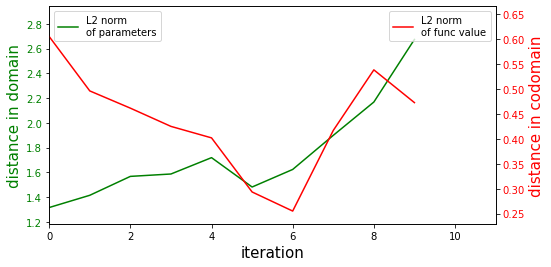

In [148]:
ana_mix= post_analysis_single(stats_mix)
ana_mix.plot_distance()

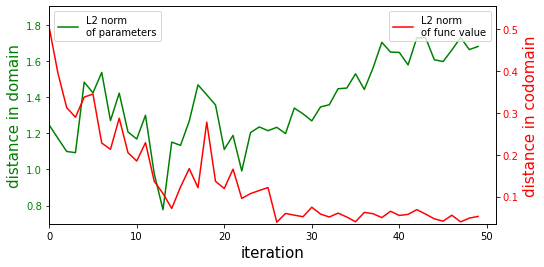

In [140]:
ana_mix= post_analysis_single(stats_mix)
ana_mix.plot_distance()

In [22]:
finalcma_ln = torch.tensor([ 0.1084, -0.6339, -0.1047, -0.2143,  0.1939,  0.0100,  0.1921, -0.6306])
verts, faces = create_mesh_optim(decoder, finalcma_ln.cuda(), N=N_MARCHING_CUBE, max_batch=int(2 ** 18))
write_verts_faces_to_file(verts, faces, "data/final_cma_ln.ply")
print("distance in domain: ", torch.norm(finalcma_ln-latent_target.cpu()))

distance in domain:  tensor(0.8387)


In [24]:
objectiveDe.func(finalcma_ln.cuda())

tensor(0.0474, device='cuda:0', grad_fn=<AddBackward0>)

In [154]:
torch.manual_seed(0)
l2reg= True
# 1 prepare data
## sphere
source_id = 999 # zywvjkvz2492e6xpq4hd1jzy2r9lht        # This will be the source shape (ie starting point)
## torus
target_id = 2 # 0bucd9ryckhaqtqvbiagilujeqzek4  
latent, latent_target = getLatentSourceAndTarget(args, source_id, target_id)
latent = latent.detach()

# 2 prepare model
decoder = constructDecoder(args)

# init and setup one experiment
exp = single_experiment()
# One experiment: setup objective function
objectiveDe = decoder_obj(latent_target, decoder)
exp.set_objective(objectiveDe)
opt = cma_es(dim=8)
ad = adam(dim=8)
optParas = {
         'x0': latent,
         'alpha': 8e-3,
         'beta_1': 0.9, 
         'beta_2': 0.999, 
         'epsilon': 1e-11, 
         'max_iter': 10,
         'tol': 1e-6,              
         'verbose': False,
         'record': False}
ad.set_parameters(optParas)
optParas ={'x0': latent,
           'std': torch.ones((8,), device=torch.device('cuda:0')) * 0.03, 
           'tol': 1e-6, 
           'adjust_func': ad, 
           'record': True, 
           'max_iter': 20,
           'cluster_size': 4,
           'verbose': True}
opt.set_parameters(optParas)
exp.set_optimizer(opt)
%time stats_mix = exp.do()



*******starting optimisation from intitial mean:  [-0.34123307 -0.47586045 -0.15240912  0.02312643  0.14862083  0.3323207
 -0.16005228 -0.12385195]
iter:  1
loss:  0.3250277042388916
latent:  [-0.21237646 -0.37339583 -0.07379272 -0.04988326  0.06892073  0.23985478
 -0.06541316 -0.04759131]


iter:  2
loss:  0.16635408997535706
latent:  [-0.06524469 -0.38193431 -0.10841159 -0.08252876  0.00152701  0.20590831
 -0.12187215 -0.13993855]


iter:  3
loss:  0.13636267185211182
latent:  [-0.1061624  -0.4959107  -0.01985103 -0.10745341  0.11295834  0.23610055
 -0.05184903 -0.1664067 ]


iter:  4
loss:  0.0360153391957283
latent:  [-0.0110886  -0.6014059   0.13873811 -0.02887025  0.16001758  0.08570793
 -0.00722598 -0.27988818]


iter:  5
loss:  0.012037101201713085
latent:  [-0.08971547 -0.5588046   0.21500453 -0.08908845  0.2828971   0.09675883
  0.02751829 -0.24927588]


iter:  6
loss:  0.02418353036046028
latent:  [ 0.03803948 -0.6091857   0.33740693 -0.06827381  0.21323988  0.17096902
 -0

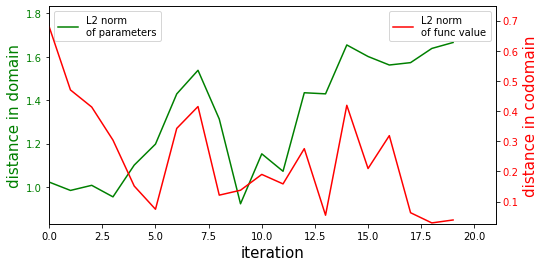

In [155]:
ana_mix= post_analysis_single(stats_mix)
ana_mix.plot_distance()

In [9]:
finalcma = torch.tensor([-0.0148, -0.4222,  0.1759, -0.1947,  0.0535,  0.4053,  0.1691, -0.1398])
verts, faces = create_mesh_optim(decoder, finalcma.cuda(), N=N_MARCHING_CUBE, max_batch=int(2 ** 18))
write_verts_faces_to_file(verts, faces, "data/final_cma_adam.ply")
print("distance in domain: ", torch.norm(finalcma-latent_target.cpu()))

tensor(0.4955)

In [15]:
objectiveDe.func(finalcma.cuda())

tensor(0.0077, device='cuda:0', grad_fn=<AddBackward0>)

In [4]:
torch.manual_seed(0)
l2reg= True
# 1 prepare data
## sphere
source_id = 999 # zywvjkvz2492e6xpq4hd1jzy2r9lht        # This will be the source shape (ie starting point)
## torus
target_id = 2 # 0bucd9ryckhaqtqvbiagilujeqzek4  
latent, latent_target = getLatentSourceAndTarget(args, source_id, target_id)
latent = latent.detach()

# 2 prepare model
decoder = constructDecoder(args)

# init and setup one experiment
exp = single_experiment()
# One experiment: setup objective function
objectiveDe = decoder_obj(latent_target, decoder)
exp.set_objective(objectiveDe)
opt = cma_es(dim=8)
ad = adam(dim=8)
optParas = {
         'x0': latent,
         'alpha': 8e-3,
         'beta_1': 0.9, 
         'beta_2': 0.999, 
         'epsilon': 1e-11, 
         'max_iter': 50,
         'tol': 5e-2,              
         'verbose': False,
         'record': False}
ad.set_parameters(optParas)
optParas ={'x0': latent,
           'std': torch.ones((8,), device=torch.device('cuda:0')) * 0.03, 
           'tol': 5e-2, 
           'adjust_func': ad, 
           'record': True, 
           'max_iter': 50,
           'cluster_size': 4,
           'verbose': True}

opt.set_parameters(optParas)
exp.set_optimizer(opt)
%time stats_mix = exp.do()



*******starting optimisation from intitial mean:  [-0.34123307 -0.47586045 -0.15240912  0.02312643  0.14862083  0.3323207
 -0.16005228 -0.12385195]
iter:  1
loss:  0.45844048261642456
latent:  [-0.35700276 -0.5045094  -0.13516667 -0.01671002  0.07458635  0.29431602
 -0.11029544 -0.15211198]


iter:  2
loss:  0.4412264823913574
latent:  [-0.339854   -0.51189446 -0.1159486  -0.02328469  0.02979162  0.28469104
 -0.09086286 -0.15752283]


iter:  3
loss:  0.40059083700180054
latent:  [-0.3626414  -0.4902029  -0.10079882 -0.01000142  0.06007109  0.20199098
 -0.09129261 -0.09566546]


iter:  4
loss:  0.3782046139240265
latent:  [-0.32037714 -0.53194267 -0.05229252 -0.01154272  0.06097298  0.16916986
 -0.11521178 -0.09173471]


iter:  5
loss:  0.3367445468902588
latent:  [-0.2765021  -0.4883282  -0.04250494 -0.03884811  0.05364392  0.15892854
 -0.10863043 -0.06587067]


iter:  6
loss:  0.2776069939136505
latent:  [-0.22183919 -0.4693873  -0.00937716 -0.09823465  0.07988283  0.09060039
 -0.07

In [38]:
valss

array([10.        ,  0.48387697,  0.45144057,  0.4200431 ,  0.38966563,
        0.3646955 ,  0.33032584,  0.24145205,  0.14139736,  0.14307857,
        0.08214378,  0.05839917,  0.1235139 ,  0.17618005,  0.07110529,
        0.08290716,  0.11216877,  0.10735278,  0.1294121 ,  0.10368411,
        0.04258901,  0.07582548,  0.09231174,  0.06740605,  0.07093627,
        0.09701096,  0.0957434 ,  0.08550449,  0.08155181,  0.07170317,
        0.03137009,  0.0295181 ,  0.03606441,  0.0686722 ,  0.08620561,
        0.05670786,  0.04805413,  0.01928438,  0.06850918,  0.06350192,
        0.037347  ,  0.06135857,  0.0549577 ,  0.05555196,  0.0763974 ,
        0.08335992,  0.05528327,  0.02786884,  0.03798852,  0.03467865,
        0.0169612 ], dtype=float32)

In [ ]:
for i, mat in enumerate(distn):
    print(i)
    print(mat)
    print('\n')

In [43]:
argss = stats_mix['arg']
valss = stats_mix['val'].mean(axis=1)

dist = argss.reshape(-1, 1, 4, 8) - argss.reshape(-1, 4, 1, 8)
unit = np.linalg.norm(latent.detach().cpu().numpy() - latent_target.cpu().numpy())
distn = np.linalg.norm(dist, axis=(3)) / unit

mask = np.triu(np.ones((4,4)), 0)

/home/qiu/miniconda3/envs/lowCuda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


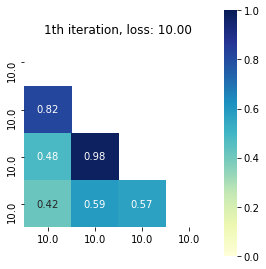

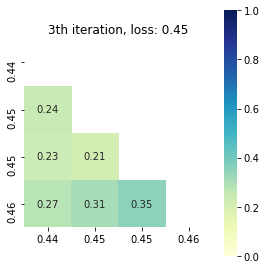

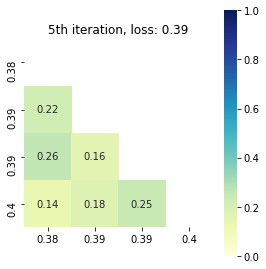

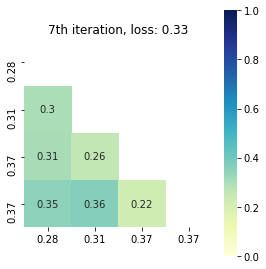

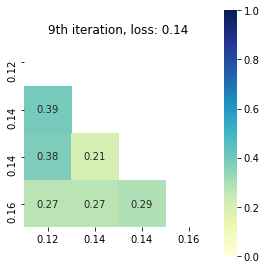

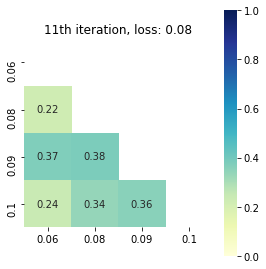

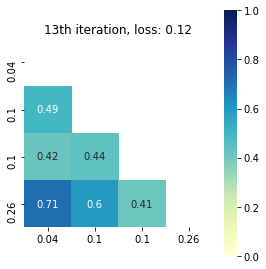

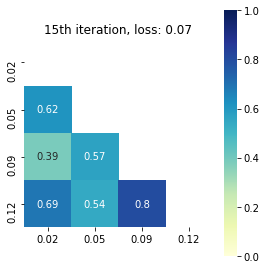

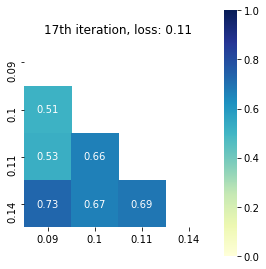

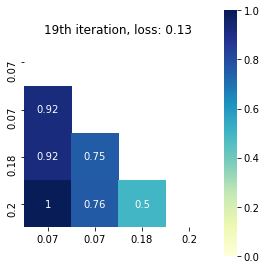

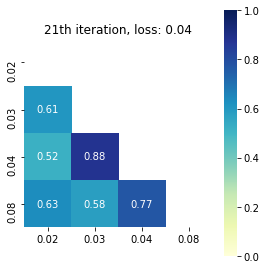

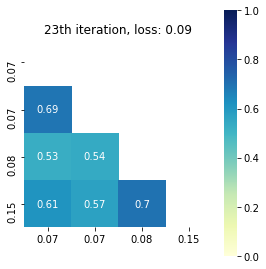

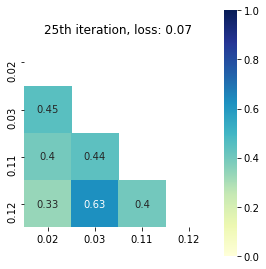

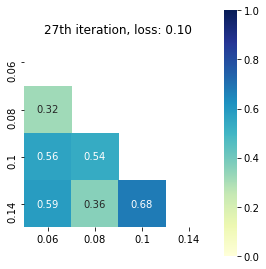

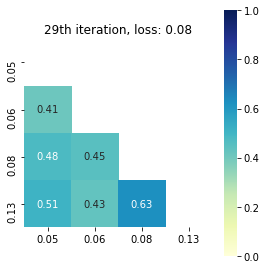

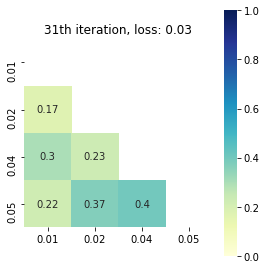

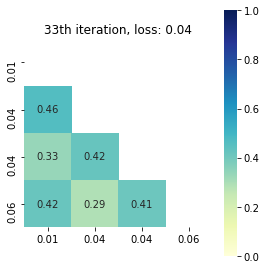

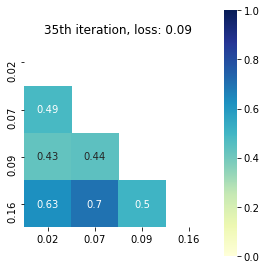

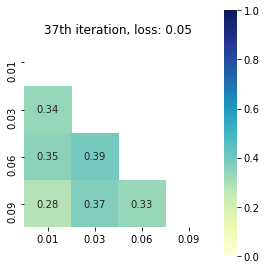

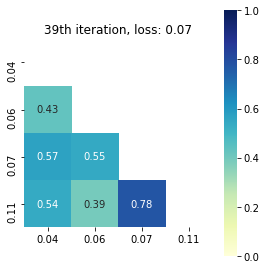

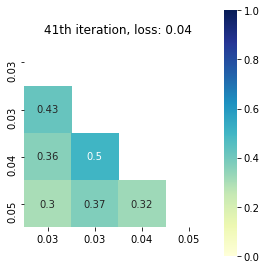

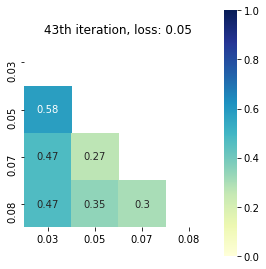

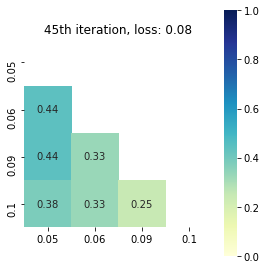

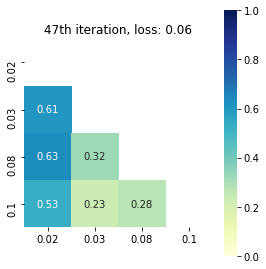

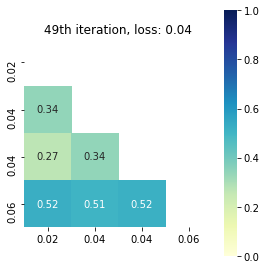

In [53]:
n = int(argss.shape[0]/2)
for i in range(n):
    figure, ax = plt.subplots(figsize=(4, 4))
    figure.tight_layout()
    ax.set_title("%dth iteration, loss: %.2f"%(i*2+1, valss[i*2].round(2)))
    axsns = sns.heatmap(distn[i*2], mask=mask, vmin=0, vmax=1, ax=ax, annot=True, square=True,  cmap="YlGnBu")
    axsns.set_xticklabels(stats_mix['val'][i*2].round(2))
    axsns.set_yticklabels(stats_mix['val'][i*2].round(2))

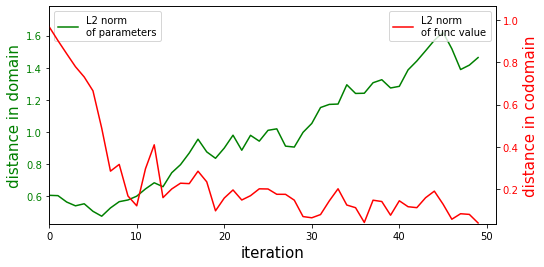

In [32]:
ana_mix= post_analysis_single(stats_mix)
ana_mix.plot_distance()

In [16]:
finalcma_ad_long = torch.tensor([0.3219, -0.7593, -0.5604,  0.9984, -0.1941, -0.3315,  0.2643, -0.1521])
verts, faces = create_mesh_optim(decoder, finalcma_ad_long.cuda(), N=N_MARCHING_CUBE, max_batch=int(2 ** 18))
write_verts_faces_to_file(verts, faces, "data/final_cma_adam_long.ply")
print("distance in domain: ", torch.norm(finalcma_ad_long-latent_target.cpu()))

distance in domain:  tensor(1.3447)


In [21]:
objectiveDe.func(finalcma_ad_long.cuda())

tensor(0.0098, device='cuda:0', grad_fn=<AddBackward0>)

In [17]:
np.linalg.norm(stats_mix['arg'][-1][0] - latent.detach().cpu().numpy())

1.4360023

In [14]:
np.linalg.norm(stats_mix['found_optimal'].cpu().numpy() - latent_target.cpu().numpy())

1.480167

In [15]:
np.linalg.norm(stats_mix['found_optimal'].cpu().numpy() - latent.cpu().numpy())

1.4360023